# Working with Spotify Data
** Prepared By: Anuj Verma **

*The objective of this exercise is to experiment with DecisionTrees and Naive Bayes classifiers with multiple (same size) samples as training and test sets (in other words, repeating the holdout procedure). This will lead to a more robust model using Decision Trees and gives us more confidence in our model's predictive power.*

In [2]:
import pandas as pd
import numpy as np

#import itertools
#from collections import defaultdict
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline

#import support file
import support_file as sf

In [3]:
#Load the data
data = pd.read_csv('Spotify_Combined.csv',index_col='index')

In [4]:
data.shape

(1420, 18)

In [5]:
data.head()

,id,name,uri,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,mood(s)
index,,,,,,,,,,,,,,,,,,
0,4dn6rw5Ze1uWrLm1uOk1gu,Stockholm Sweetnin',spotify:track:4dn6rw5Ze1uWrLm1uOk1gu,"Scott Hamilton, Jesper Lundgaard, Jan Lundgren...",0.838,0.602,475680,0.302,0.9070,8,0.1130,-11.627,1,0.0427,119.758,4,0.300,dinner
1,6CDQBADsdzJwc3qZ3OPDHH,Almost Like Being in Love,spotify:track:6CDQBADsdzJwc3qZ3OPDHH,"Red Garland, Paul Chambers, Art Taylor,",0.873,0.571,290293,0.346,0.5190,0,0.0980,-12.569,0,0.0409,93.885,4,0.687,dinner
2,00CIFNT8kOm61dupysBFp8,Garden of Delight,spotify:track:00CIFNT8kOm61dupysBFp8,"Jan Lundgren Trio,",0.876,0.427,291862,0.287,0.8740,11,0.1330,-19.834,1,0.0346,104.407,4,0.467,dinner
3,2z6D5bIA9Wprdqi1B8nnVh,New Orleans,spotify:track:2z6D5bIA9Wprdqi1B8nnVh,"Wynton Marsalis,",0.714,0.644,340693,0.205,0.0482,10,0.0510,-16.005,1,0.0397,118.314,4,0.411,dinner
4,1ykNjOQbYJgZE3pflVB9MN,The Sequel,spotify:track:1ykNjOQbYJgZE3pflVB9MN,"Wingspan,",0.703,0.532,482360,0.364,0.6180,9,0.0602,-13.068,0,0.0297,127.166,4,0.271,dinner


In [6]:
#rename the target column name
data = data.rename(columns={'mood(s)':'moods'})

<b> Note: I will Skip the Data Exploration for this notebook as it is already covered in previous one.

In [7]:
print('Number of records in dataset:',data.shape[0])
print('Number of attributes in dataset:',data.shape[1])

Number of records in dataset: 1420
Number of attributes in dataset: 18


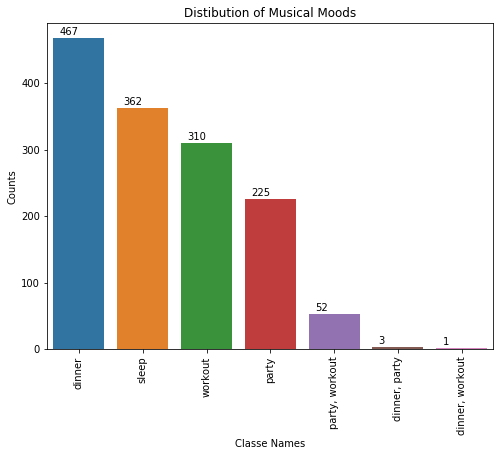

In [8]:
sf.plot_count_distribution(data,'moods','Distibution of Musical Moods')

### ```Issues in Dataset```
From above plot, it is clear that we are dealing with a highly unbalanced data. This might impact the performance of our model as we will get biased results. 
<br> We will need to check the sensitivity and specificity of our data in addition to checking the RMSE values of our models as this will provide a correct measure to check the performance of our model.

#### Ways to handle very few class instances/representatives in multi-class classification
<ul>    
<li> Binning: Combine minority class with other classes to create a new class label.
        <br>The decision of what classes to be combined, should be made after carefully investigating the two classes and there relationship to each other. This can be done by number of methods:
        <ul>
        <li>
        Check the mean values of each attribute and comparing them one-by-one for each class and thus finding the class that is more comparable the minority class.
        <li>Use kNN for the instances of minority class and locate the class nearest to these instances. Note: k-value for kNN needs to be optimized before making any decision)
        <li>Other approaches that I am not aware of
        </ul>
<li> Clustering: The clustering of the data can be performed to create new classes with the desired number of clusters and using these new classes for generating predictions.
<li> Oversampling with Synthetic Data: Create synthetic data with SMOTE and try to balance the unbalanced classes. The oversampling may not be desired for very few instance classes and should be used cautiosly.
<li> Removal: Delete the instances of minority class. This is the easiest option and could be the only option left if any of above method does not give a satisfactory answer. However, We should keep in mind that deleting the instances of the minority class means that we are not training our model to identify these minority class. This means that, if we receive instances from this minority class in future then our model will fail to classify these instances correctly in minority class. This could be a subject of discussion as we will need to analyse how often can we receive instances from this minority class.
</ul>     

### For now, I will Remove classes `[dinner, party]` and `[dinner, workout]` since these have very few class representatives


In [9]:
idx = data.index[data['moods'].isin(['dinner, workout','dinner, party'])]

In [10]:
data_clean = data.drop(idx)

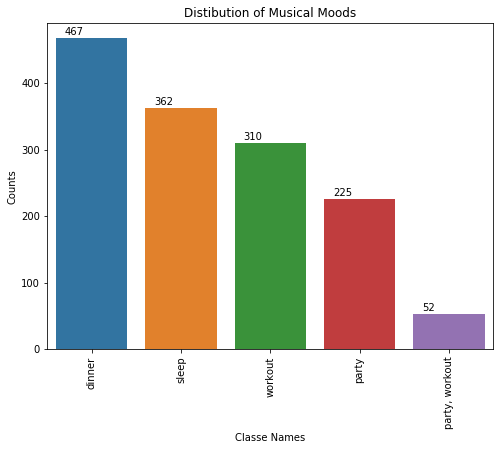

In [11]:
sf.plot_count_distribution(data_clean,'moods','Distibution of Musical Moods')

<b> The data set is still highly unbalanced. We will need to make it balanced in order to improve its performance. Later in teh notebook, we will use `SMOTE` oversampling and create synthetic data to balance the classes.

In [12]:
#remove non-significant columns
data_clean.drop(['id','name','uri','artist'],axis=1,inplace=True)

In [13]:
#save cleaned data

data_clean.to_csv('spotify_clean.csv',index = False)

In [14]:
#load clean dataset
spotify = pd.read_csv('spotify_clean.csv')

In [15]:
spotify.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,moods
0,0.838,0.602,475680,0.302,0.9070,8,0.1130,-11.627,1,0.0427,119.758,4,0.300,dinner
1,0.873,0.571,290293,0.346,0.5190,0,0.0980,-12.569,0,0.0409,93.885,4,0.687,dinner
2,0.876,0.427,291862,0.287,0.8740,11,0.1330,-19.834,1,0.0346,104.407,4,0.467,dinner
3,0.714,0.644,340693,0.205,0.0482,10,0.0510,-16.005,1,0.0397,118.314,4,0.411,dinner
4,0.703,0.532,482360,0.364,0.6180,9,0.0602,-13.068,0,0.0297,127.166,4,0.271,dinner


## Create Robust DecisionTree and Naive-Bayes Models

    - Create the DecisionTree and Naive-Bayes models and hyper-tune the parameters for best performance. 
    - Perform Holdout partitioning for n-epochs (min 30) to create robust and stable measures
    - For best parameter configuration, report
        Misclassification matrix, accuracy, sensitivity, and specificity
    - Compare performances of Decision Tree and Naive Bayes models after n-epochs.

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split

In [17]:
#before train test split, let us split our target variable from attributes
colnames = spotify.columns.values

y = spotify['moods']
x = spotify[colnames[:-1]]

In [18]:
x.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.838,0.602,475680,0.302,0.9070,8,0.1130,-11.627,1,0.0427,119.758,4,0.300
1,0.873,0.571,290293,0.346,0.5190,0,0.0980,-12.569,0,0.0409,93.885,4,0.687
2,0.876,0.427,291862,0.287,0.8740,11,0.1330,-19.834,1,0.0346,104.407,4,0.467
3,0.714,0.644,340693,0.205,0.0482,10,0.0510,-16.005,1,0.0397,118.314,4,0.411
4,0.703,0.532,482360,0.364,0.6180,9,0.0602,-13.068,0,0.0297,127.166,4,0.271


In [19]:
#x,y,dt_param_grid,
#split the data
test_split_size = 0.33
n_epochs = 30
dt_param_grid = {'criterion':['gini','entropy'],
                  'max_depth':[5,10,15,30,40],
                  'min_sample_leaf': [1,5,10,20],
                  'max_features': ['sqrt','log2',None],
                  'random_state': [10]
                }

#initialize the dataframe to store the results
results = pd.DataFrame(data=None,index=range(n_epochs),\
                           columns = ['run_id','dt_train_acc','dt_train_sensitivity','dt_train_specificity',\
                                      'dt_test_acc','dt_test_sensitivity','dt_test_specificity',\
                                      'nb_train_acc','nb_train_sensitivity','nb_train_specificity',\
                                      'nb_test_acc','nb_test_sensitivity','nb_test_specificity'])
for idx in range(n_epochs):
    results.loc[idx,'run_id'] = idx+1
    
    xtrain,xtest,ytrain, ytest = train_test_split(x,y,test_size = test_split_size,stratify = y)

    #initialize DT instance
    dtclf = DecisionTreeClassifier()

    #Find best results for DT by Hyper-parameterization
    dt_train_results,dt_test_results = sf.run_model_evaluations(xtrain,ytrain,xtest,ytest,dtclf,dt_param_grid,None)
    
    #store DT results
    results.loc[idx,'dt_train_acc'],results.loc[idx,'dt_train_sensitivity'],results.loc[idx,'dt_train_specificity'] =dt_train_results
    results.loc[idx,'dt_test_acc'],results.loc[idx,'dt_test_sensitivity'],results.loc[idx,'dt_test_specificity'] =dt_test_results
    
    #initialize Naive Bayes instance
    nbclf = GaussianNB()
    nb_train_results = sf.fit_and_evaluate(xtrain,ytrain,xtrain,ytrain,nbclf)
    nb_test_results = sf.fit_and_evaluate(xtrain,ytrain,xtest,ytest,nbclf)
    
    #store NB results
    results.loc[idx,'nb_train_acc'],results.loc[idx,'nb_train_sensitivity'],results.loc[idx,'nb_train_specificity'] =nb_train_results
    results.loc[idx,'nb_test_acc'],results.loc[idx,'nb_test_sensitivity'],results.loc[idx,'nb_test_specificity'] =nb_test_results
    

In [20]:
print('Accuracy Results for {} iterations'.format(n_epochs))
results[['dt_train_acc','dt_test_acc','nb_train_acc','nb_test_acc']].agg(['mean','var','std']).T

Accuracy Results for 30 iterations


,mean,var,std
dt_train_acc,0.814909,0.002177,0.046655
dt_test_acc,0.751709,0.000176,0.013248
nb_train_acc,0.460513,0.000463,0.021525
nb_test_acc,0.463319,0.000791,0.028119


### Use t-pair test
    Compare the mean accuracy of the Naïve Bayes and the mean accuracy of the Decision tree

In [21]:
from scipy import stats

    The following is a two-sided test for the null hypothesis (h0) that 2 independent samples Decision Tree(DT) accuracy and Naive Bayes (NB) accuracy have identical mean (expected) values. The alternate hypothesis is that there is significant difference between DT accuracy and NB accuracy mean values.

In [22]:
tvalue,pvalue = stats.ttest_ind(results['dt_train_acc'],results['nb_train_acc'],equal_var=False)
print('T-value = {}, P-value = {}'.format(tvalue,pvalue))

T-value = 37.77864205055499, P-value = 2.237535055289659e-33


<b>Discussion:</b> From the above results, p-value is very small (almost zero). This implies that there is a significant difference between the mean accuracies of DT and NB models.
    

## Experiment with Varying train-test split sizes
    
    The objective of this exercise is to analyze the performance of the previously trained Naïve Bayes and decision trees classifiers as a function of the sample size. 
    
    Vary the training sizes as [25%, 35%, 45%, 55%, 65%, 75%, 85%] and Plot the resubstitution error and generalization error for Decision Tree and Naive Bayes

In [23]:
#initialize variables
train_split_size = np.array([.25,.35,.45,.55,.65,.75,.85])
test_split_size = 1-train_split_size
n_epochs = 30
dt_param_grid = {'criterion':['gini','entropy'],
                  'max_depth':[5,10,15,30,40],
                  'min_sample_leaf': [1,5,10,20],
                  'max_features': ['sqrt','log2',None],
                  'random_state': [10]
                }

#initialize variables to store results
error_results = np.zeros((len(test_split_size),4)) 

for idx in range(len(train_split_size)):
    acc_results = sf.holdout_partition_and_eval(x,y,test_split_size[idx],n_epochs,dt_param_grid)
    error_results[idx] = 1-acc_results


Calculate Results of 30 iterations for test split size: 0.75
Calculate Results of 30 iterations for test split size: 0.65
Calculate Results of 30 iterations for test split size: 0.55
Calculate Results of 30 iterations for test split size: 0.45
Calculate Results of 30 iterations for test split size: 0.35
Calculate Results of 30 iterations for test split size: 0.25
Calculate Results of 30 iterations for test split size: 0.15


In [24]:
error_results

array([[0.19350282, 0.27959824, 0.51544256, 0.52473321],
       [0.19420875, 0.26793341, 0.52835017, 0.54241766],
       [0.19492412, 0.26576808, 0.54123496, 0.54540009],
       [0.20317052, 0.25632184, 0.53329049, 0.54096134],
       [0.20923913, 0.25040323, 0.53735507, 0.54348118],
       [0.20627746, 0.23973635, 0.53716259, 0.54011299],
       [0.18326406, 0.23223787, 0.53524522, 0.5456964 ]])

#### Plot the error results

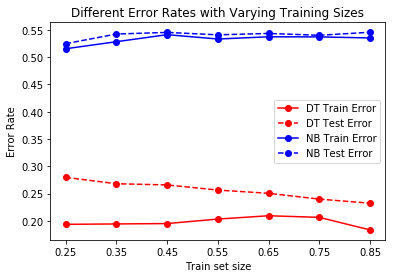

In [25]:
%matplotlib inline

plt.Figure(figsize = (10,12))

p1, = plt.plot(train_split_size,error_results[:,0:1].ravel(),'ro-',label = 'DT Train Error')
p2, = plt.plot(train_split_size,error_results[:,1:2].ravel(),'ro--',label = 'DT Test Error')
p3, = plt.plot(train_split_size,error_results[:,2:3].ravel(),'bo-',label = 'NB Train Error')
p4, = plt.plot(train_split_size,error_results[:,3:4].ravel(),'bo--',label = 'NB Test Error')

plt.title('Different Error Rates with Varying Training Sizes')
plt.xticks(train_split_size)
plt.xlabel('Train set size')
plt.ylabel('Error Rate')
plt.legend()
plt.show()

<b>Analysis</b>: For Naive Bayes error ratio is minimum around 0.45 and 0.65 train size. For Decision Tree the error is minimum around 0.85.

Since we have obtained these results after 30-repeated holdout partitionings, both our models show stable results. Thus we can say that for this particular dataset the best train_test_split for NB would be around 65% and for DT would be around 85%.

However, we cannot generalize our finding from this dataset. 

## Additional Datasets
    Repeat Problem 2 on the following additional datasets and interpret the results:
        winered.data: https://archive.ics.uci.edu/ml/datasets/Wine+Quality
        banknote.data: https://archive.ics.uci.edu/ml/datasets/banknote+authentication


In [27]:
wine = pd.read_csv('winequality-red.csv',delimiter=';')

In [28]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [29]:
wine.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


In [30]:
wine.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [31]:
wine.shape

(1599, 12)

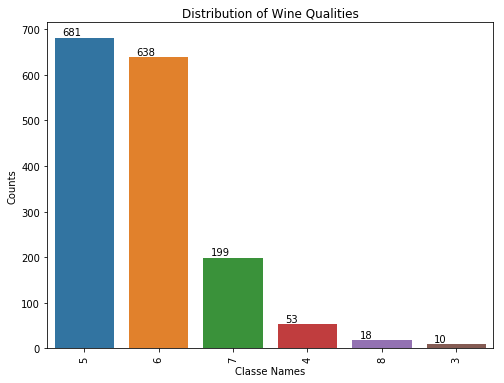

In [32]:
sf.plot_count_distribution(wine,'quality','Distribution of Wine Qualities')

In [33]:
target= wine['quality']
features = wine[wine.columns.values[:-1]]

In [34]:
print(target.shape)
print(features.shape)

(1599,)
(1599, 11)


In [35]:
#initialize variables
train_split_size = [.25,.35,.45,.55,.65,.75,.85]
n_epochs = 30
dt_param_grid = {'criterion':['gini','entropy'],
                  'max_depth':[5,10,15,30,40],
                  'min_sample_leaf': [1,5,10,20],
                  'max_features': ['sqrt','log2',None],
                  'random_state': [10]
                }

#initialize variables to store results
error_results = np.zeros((len(train_split_size),4)) 

for idx in range(len(train_split_size)):
    acc_results = sf.holdout_partition_and_eval(features,target,train_split_size[idx],n_epochs,dt_param_grid)
    error_results[idx] = 1-acc_results


Calculate Results of 30 iterations for test split size: 0.25
Calculate Results of 30 iterations for test split size: 0.35
Calculate Results of 30 iterations for test split size: 0.45
Calculate Results of 30 iterations for test split size: 0.55
Calculate Results of 30 iterations for test split size: 0.65
Calculate Results of 30 iterations for test split size: 0.75
Calculate Results of 30 iterations for test split size: 0.85


In [36]:
error_results

array([[0.03005282, 0.36508333, 0.43461218, 0.46008333],
       [0.10709015, 0.38017857, 0.43991017, 0.46160714],
       [0.13773227, 0.39282407, 0.44220705, 0.45657407],
       [0.26230876, 0.40655303, 0.44483078, 0.47094697],
       [0.35324985, 0.41445513, 0.44680978, 0.48548077],
       [0.346533  , 0.42072222, 0.45288221, 0.50258333],
       [0.3474198 , 0.43009804, 0.43026499, 0.50262255]])

#### Plot the error results

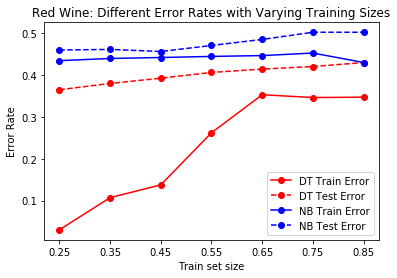

In [37]:
%matplotlib inline

plt.Figure(figsize = (10,12))

p1, = plt.plot(train_split_size,error_results[:,0:1].ravel(),'ro-',label = 'DT Train Error')
p2, = plt.plot(train_split_size,error_results[:,1:2].ravel(),'ro--',label = 'DT Test Error')
p3, = plt.plot(train_split_size,error_results[:,2:3].ravel(),'bo-',label = 'NB Train Error')
p4, = plt.plot(train_split_size,error_results[:,3:4].ravel(),'bo--',label = 'NB Test Error')

plt.title('Red Wine: Different Error Rates with Varying Training Sizes')
plt.xticks(train_split_size)
plt.xlabel('Train set size')
plt.ylabel('Error Rate')
plt.legend()
plt.show()

<b>Analysis:</b> For DT, the train_split_size could be anything from 0.45 to 0.75. Similarly for NB, the split size could be between 0.45-0.75.

It is difficult to name one best split size since the rate of change in error is very small.

#### Banknote data

In [38]:
bank = np.loadtxt('data_banknote_authentication.txt',delimiter=',')
bank.shape

(1372, 5)

In [39]:
bank[:5]

array([[ 3.6216 ,  8.6661 , -2.8073 , -0.44699,  0.     ],
       [ 4.5459 ,  8.1674 , -2.4586 , -1.4621 ,  0.     ],
       [ 3.866  , -2.6383 ,  1.9242 ,  0.10645,  0.     ],
       [ 3.4566 ,  9.5228 , -4.0112 , -3.5944 ,  0.     ],
       [ 0.32924, -4.4552 ,  4.5718 , -0.9888 ,  0.     ]])

In [40]:
features = bank[:,:-1]
target = bank[:,-1]

In [41]:
#initialize variables
train_split_size = [.25,.35,.45,.55,.65,.75,.85]
n_epochs = 30
dt_param_grid = {'criterion':['gini','entropy'],
                  'max_depth':[5,10,15,30,40],
                  'min_sample_leaf': [1,5,10,20],
                  'max_features': ['sqrt','log2',None],
                  'random_state': [10]
                }

#initialize variables to store results
error_results = np.zeros((len(train_split_size),4)) 

for idx in range(len(train_split_size)):
    acc_results = sf.holdout_partition_and_eval(features,target,train_split_size[idx],n_epochs,dt_param_grid)
    error_results[idx] = 1-acc_results

Calculate Results of 30 iterations for test split size: 0.25
Calculate Results of 30 iterations for test split size: 0.35
Calculate Results of 30 iterations for test split size: 0.45
Calculate Results of 30 iterations for test split size: 0.55
Calculate Results of 30 iterations for test split size: 0.65
Calculate Results of 30 iterations for test split size: 0.75
Calculate Results of 30 iterations for test split size: 0.85


In [42]:
error_results

array([[0.00236476, 0.00495627, 0.15963719, 0.15617104],
       [0.00246914, 0.00783091, 0.15824916, 0.15571726],
       [0.00114943, 0.00906149, 0.15778073, 0.15442287],
       [0.00027012, 0.01231788, 0.15375473, 0.15871965],
       [0.00222222, 0.01263079, 0.15229167, 0.1577728 ],
       [0.004276  , 0.01720117, 0.15199223, 0.15704568],
       [0.00276423, 0.02802057, 0.14406504, 0.15889746]])

#### Plot the error results

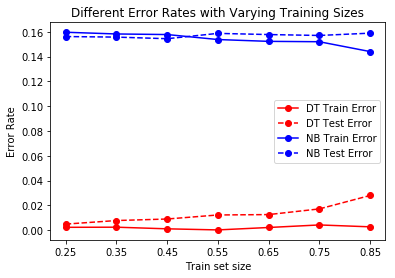

In [43]:
%matplotlib inline

plt.Figure(figsize = (10,12))

p1, = plt.plot(train_split_size,error_results[:,0:1].ravel(),'ro-',label = 'DT Train Error')
p2, = plt.plot(train_split_size,error_results[:,1:2].ravel(),'ro--',label = 'DT Test Error')
p3, = plt.plot(train_split_size,error_results[:,2:3].ravel(),'bo-',label = 'NB Train Error')
p4, = plt.plot(train_split_size,error_results[:,3:4].ravel(),'bo--',label = 'NB Test Error')

plt.title('Different Error Rates with Varying Training Sizes')
plt.xticks(train_split_size)
plt.xlabel('Train set size')
plt.ylabel('Error Rate')
plt.legend()
plt.show()

<b>Analysis:</b> The error rate for train and test set is very low overall for Decision Tree, since there are only 4 features in this dataset, the decision tree is very accurate in its predictions. However, we should note that there are more chances of overfitting the model in DT.

For DT, the best train_split_size could be anything from 0.25 to 0.65.  For NB, the best train_split_size could be 0.85 since the train and test errors are lowest at this point.

It is difficult to name one best split size since the rate of change in error is very small.